In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST

In [14]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p
    
def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [ ]:
# class Prior(nn.Module):
#     def __init__(self, device='cpu'):
#         super(Prior, self).__init__()
#         self.device = device

#     def forward(self, z):
#         # Calculate the log probability of the prior
#         # TODO which value for z to use
#         log_p_z = log_standard_normal(z)

#         return log_p_z

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device='cpu'):
        super(Encoder, self).__init__()
        self.device = device
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.x_2_h = nn.Linear(input_dim, hidden_dim)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
    
    @staticmethod
    def reparameterization(mu_e, log_var_e):
        std = torch.exp(0.5*log_var_e)
        eps = torch.randn_like(std)
        z = mu_e + (eps * std)
        return z

    def forward(self, x):
        h = F.relu(self.x_2_h(x))
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
  
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

In [94]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, device='cpu'):
        super(Decoder, self).__init__()
        self.device = device
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.z_2_h = nn.Linear(latent_dim, hidden_dim)
        self.h_2_x = nn.Linear(hidden_dim, output_dim)


    def forward(self, z):
        h = F.relu(self.z_2_h(z))
        x_hat = F.sigmoid(self.h_2_x(h))
        return x_hat

In [ ]:
class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim=784, hidden_dim=400, latent_dim=20)
        self.decoder = Decoder(latent_dim=20, hidden_dim=400, output_dim=784)
        #self.prior = Prior()

    def forward(self, x, reduction='mean'):
        z, mu, log_var = self.encoder.forward(x)
        x_hat = self.decoder.forward(z)
  
        return x_hat, z, mu, log_var
    
    def elbo(self, x, x_hat, z, mu, log_var):
        # TODO: Apply some form of normalization as this reconstruction loss is very large.
        # We can use this and reduce it by sum as we're using bernoulli distribution. We can divide it by batch size to get the average.
        RE = F.binary_cross_entropy(x_hat, x, reduction='sum')
       # print(re.item())
        #print(log_var)
        #kl = log_normal_diag(z, mu, log_var, reduction='sum') - log_normal_diag(z, torch.zeros_like(z), torch.zeros_like(z), reduction='sum')
        #print(kl.item())
        #nelbo = -(re - kl)
        KLD      = - 0.5 * torch.sum(1+ log_var - mu.pow(2) - log_var.exp())

        return RE + KLD


In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

dataset = MNIST('./files/', train=True, download=True,
                      transform=transforms_train
)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

#-dataloaders
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:


# Implement the training loop

# Custom weight initialization function using built-in PyTorch initializers
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Initialize the model and apply the custom weight initialization
model = VAE().to(device)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()
losses = []
for epoch in range(30):
  for indx_batch, (batch, _) in enumerate(train_loader):
          batch = batch.to(device)
          # Flattne the image
          batch = batch.view(batch.size(0), -1)
          
          optimizer.zero_grad()

          x_hat, z, mu, log_var = model.forward(batch)
          loss = model.elbo(batch, x_hat, z, mu, log_var)

          loss.backward()
          optimizer.step()
  print(f'Epoch {epoch} Loss: {loss.item()}')
  losses.append(loss.item())
#
print('Training finished')


Epoch 0 Loss: 19101.96875
Epoch 1 Loss: 16675.958984375
Epoch 2 Loss: 15934.7431640625
Epoch 3 Loss: 14118.1337890625
Epoch 4 Loss: 14503.7607421875
Epoch 5 Loss: 12962.8984375
Epoch 6 Loss: 13089.103515625
Epoch 7 Loss: 13307.8037109375
Epoch 8 Loss: 11448.744140625
Epoch 9 Loss: 12123.37890625
Epoch 10 Loss: 12374.86328125
Epoch 11 Loss: 12508.28125
Epoch 12 Loss: 11662.150390625
Epoch 13 Loss: 11845.048828125
Epoch 14 Loss: 11594.51171875
Epoch 15 Loss: 11635.271484375
Epoch 16 Loss: 11606.0205078125
Epoch 17 Loss: 11326.3251953125
Epoch 18 Loss: 11497.68359375
Epoch 19 Loss: 11674.939453125
Epoch 20 Loss: 11751.2607421875
Epoch 21 Loss: 11331.64453125
Epoch 22 Loss: 11384.8994140625
Epoch 23 Loss: 10862.3203125
Epoch 24 Loss: 10991.3603515625
Epoch 25 Loss: 10818.01953125
Epoch 26 Loss: 11162.8603515625
Epoch 27 Loss: 11054.755859375
Epoch 28 Loss: 11020.748046875
Epoch 29 Loss: 11168.3671875
Training finished


30


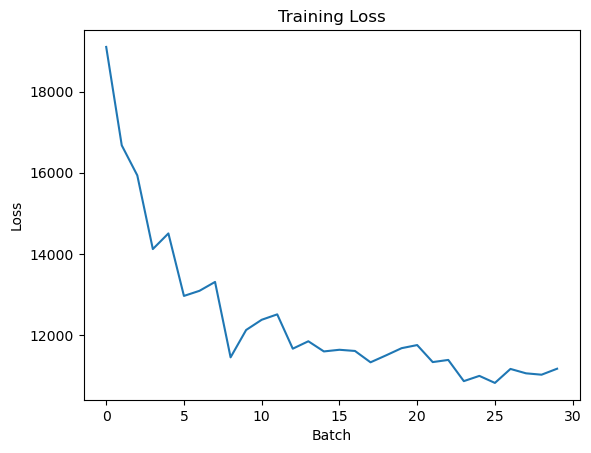

In [109]:
print(len(losses))

# Plot the loss
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

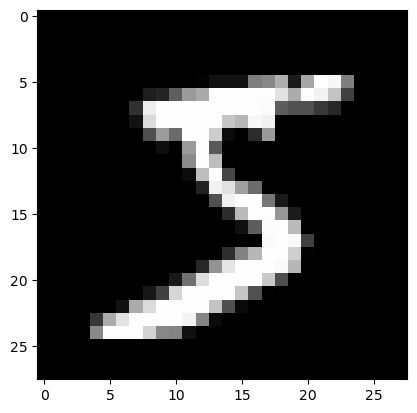

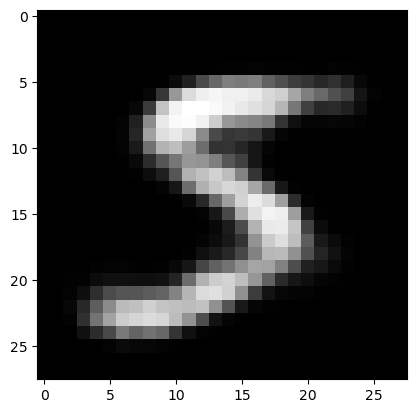

In [ ]:
# Plot the reconstruction of the first image in the dataset
model.eval()
with torch.no_grad():
    x = dataset[0][0].to(device)
    x = x.view(1, -1)
    plt.imshow(x.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.show()
    x_hat, _, _, _ = model.forward(x)
    x_hat = x_hat.view(1, 28, 28)
    x_hat = x_hat.cpu().numpy()
    x_hat = np.squeeze(x_hat)
    plt.imshow(x_hat, cmap='gray')
    plt.show()



In [330]:
# Test a convolutional layer for the encoder
x = dataset[0][0].to(device)
# Ensure the image is in the shape (1, 28, 28)
image = x.unsqueeze(0) if x.dim() == 2 else x

#batch = dataset[0][0].unsqueeze(100).to(device)

print("Image shape:", image.shape)

class CNNEncoder(nn.Module):
    def __init__(self, h_dim=200 ,latent_dim=32, device='cpu'):
        super(CNNEncoder, self).__init__()
        self.device = device
        self.latent_dim = latent_dim

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding =1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=7, padding = 0)

        self.fc1 = nn.Linear(16, h_dim)
        self.fc_mu = nn.Linear(h_dim, latent_dim)
        self.fc_log_var = nn.Linear(h_dim, latent_dim)
        
    @staticmethod
    def reparameterization(mu_e, log_var_e):
        std = torch.exp(0.5*log_var_e)
        eps = torch.randn_like(std)
        z = mu_e + (eps * std)
        return z

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pool2d(h, 2, stride=2)
        h = F.relu(self.conv2(h))
        h = F.max_pool2d(h, 2, stride=2)
        h = F.relu(self.conv3(h))
        h = h.view(h.size(0), -1)
        #print(h.shape)
        h = self.fc1(h)

        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)


        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

# Test if the CNN encoder works
cnn_encoder = CNNEncoder(latent_dim=20).to(device)
z, mu, log_var = cnn_encoder.forward(x)

print(z.shape)
print(mu.shape)
print(log_var.shape)



Image shape: torch.Size([1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x1 and 16x200)

In [326]:

class CNNDecoder(nn.Module):
    def __init__(self, h_dim = 200, latent_dim=32, device='cpu'):
        super(CNNDecoder, self).__init__()
        self.device = device
        self.latent_dim = latent_dim
        self.h_dim = h_dim

        self.fc1 = nn.Linear(latent_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 16)
        self.deconv1 = nn.ConvTranspose2d(16, 16, kernel_size=7, padding=0)
        self.deconv2 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1)
        
    def forward(self, z):
        h = self.fc1(z)
        h = self.fc2(h)
        h = h.view(-1, 16, 1, 1)
        
        # How to double the size of the image with max unpooling?
        h = F.relu(F.upsample(self.deconv1(h), scale_factor=2))
        h = F.relu(F.upsample(self.deconv2(h), scale_factor=2))
        x_hat = torch.sigmoid(self.deconv3(h))
        return x_hat

        # Fully connected layers
        # x = F.relu(self.fc1(z))
        # x = F.relu(self.fc2(x))

        # # Reshape to prepare for transposed convolutions
        # x = x.view(-1, 64, 3, 3)

        # # Transposed convolutions
        # x = F.relu(F.max_unpool2d(self.deconv1(x)))
        # x = F.relu(F.max_unpool2d(self.deconv2(x), scale_factor=2))
        # x = torch.sigmoid(self.deconv3(x))
        x = self.decoder(z)

        return x

# Test if the CNN decoder works
cnn_decoder = CNNDecoder(latent_dim=20).to(device)
x_hat = cnn_decoder.forward(z)
print(x_hat.shape)
print(x.shape)


torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])


/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_34705/1431230132.py:20: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv1(h), scale_factor=2))
/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_34705/1431230132.py:21: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv2(h), scale_factor=2))


In [325]:
# Define the VAE model with the CNN encoder and decoder

class CNNVAE(nn.Module):
    def __init__(self, device='cpu'):
        super(CNNVAE, self).__init__()
        self.encoder = CNNEncoder(latent_dim=20)
        self.decoder = CNNDecoder(latent_dim=20)
        #self.prior = Prior()

    def forward(self, x, reduction='mean'):
        z, mu, log_var = self.encoder.forward(x)
        x_hat = self.decoder.forward(z)

        return x_hat, z, mu, log_var

    def elbo(self, x, x_hat, z, mu, log_var):
        RE = F.binary_cross_entropy(x_hat, x, reduction='sum')
        KLD = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return RE + KLD
    


In [331]:
# Implement the training loop

# Custom weight initialization function using built-in PyTorch initializers
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Initialize the model and apply the custom weight initialization
model = CNNVAE().to(device)
model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


model.train()
losses = []
for epoch in range(30):
  for indx_batch, (batch, _) in enumerate(train_loader):
          batch = batch.to(device)
          # Flattne the image
          # batch = batch.view(batch.size(0), -1)
          optimizer.zero_grad()

          x_hat, z, mu, log_var = model.forward(batch)

          # print(x_hat.shape)
          # print(batch.shape)

          loss = model.elbo(batch, x_hat, z, mu, log_var)

          loss.backward()
          optimizer.step()
  print(f'Epoch {epoch} Loss: {loss.item()}')
  losses.append(loss.item())
#
print('Training finished')


/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_34705/1431230132.py:20: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv1(h), scale_factor=2))
/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_34705/1431230132.py:21: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv2(h), scale_factor=2))


Epoch 0 Loss: 18117.970703125
Epoch 1 Loss: 15973.150390625
Epoch 2 Loss: 15991.482421875
Epoch 3 Loss: 15483.4013671875
Epoch 4 Loss: 14765.57421875
Epoch 5 Loss: 14842.68359375
Epoch 6 Loss: 13637.8125
Epoch 7 Loss: 14664.14453125
Epoch 8 Loss: 14179.3583984375
Epoch 9 Loss: 14176.8388671875
Epoch 10 Loss: 13710.3203125
Epoch 11 Loss: 14768.345703125
Epoch 12 Loss: 15042.9921875
Epoch 13 Loss: 14547.126953125
Epoch 14 Loss: 14861.634765625
Epoch 15 Loss: 13644.451171875
Epoch 16 Loss: 13791.107421875
Epoch 17 Loss: 14221.466796875
Epoch 18 Loss: 13201.6005859375
Epoch 19 Loss: 13962.53515625
Epoch 20 Loss: 14855.482421875
Epoch 21 Loss: 13706.841796875
Epoch 22 Loss: 14026.783203125
Epoch 23 Loss: 14209.6318359375
Epoch 24 Loss: 14382.677734375
Epoch 25 Loss: 14520.9755859375
Epoch 26 Loss: 14550.75
Epoch 27 Loss: 14099.412109375
Epoch 28 Loss: 14116.30078125
Epoch 29 Loss: 14279.8203125
Training finished


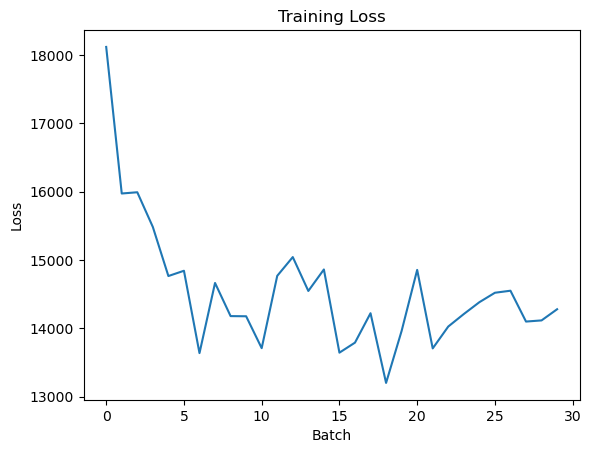

In [332]:
# Plot the loss
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


torch.Size([1, 28, 28])


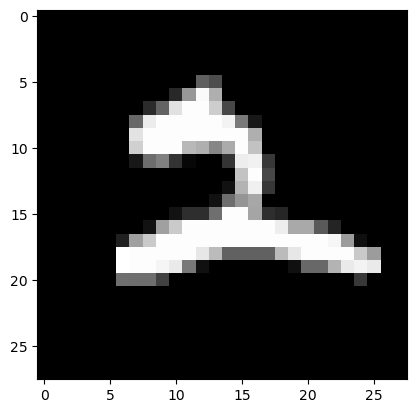

/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_34705/1431230132.py:20: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv1(h), scale_factor=2))
/var/folders/97/50twy7395gs8j3ss631vmvvw0000gp/T/ipykernel_34705/1431230132.py:21: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  h = F.relu(F.upsample(self.deconv2(h), scale_factor=2))


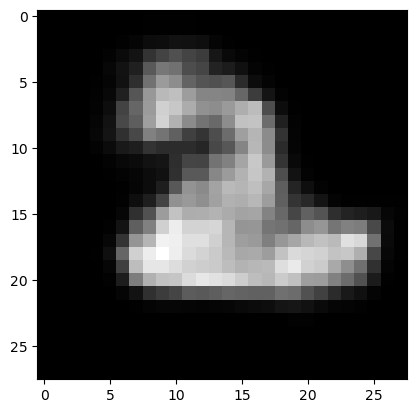

In [341]:
# Plot the reconstruction of the first image in the dataset
model.eval()
with torch.no_grad():
    x = dataset[0][0].to(device)
    print(x.shape)
    #x = x.view(1, -1)
    plt.imshow(batch[5].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.show()
    x_hat, _, _, _ = model.forward(batch)
    #x_hat = x_hat.view(1, 28, 28)
    x_hat = x_hat.cpu().numpy()
    x_hat = np.squeeze(x_hat[5])
    plt.imshow(x_hat, cmap='gray')
    plt.show()

